<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
    <font color=orange>II - 2 </font>
  Sequence to Sequence
  </div> 

  <div style="
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
    a. Machine Translation
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. <font color=orange>**Sequence to sequence**</font>


### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | |
|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 

We consider here Machine Translation between English and French. The corpus used is [EuroParl v7](http://www.statmt.org/europarl/). Ohter corpuses can be found at :

- http://www.statmt.org/
- https://www.statmt.org/wmt15/translation-task.html
- http://casmacat.eu/corpus/global-voices.html

A project highly optimized towards Seq2Seq tasks is [openNMT](https://github.com/OpenNMT/OpenNMT-py)

# Packages

In [1]:
from __future__ import unicode_literals, print_function, division

import sys
import warnings
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.5.0
DL device : cuda


In [2]:
path_to_DL4NLP = os.path.dirname(os.getcwd())
path_to_data   = 'D:\\data'

In [3]:
sys.path.append(path_to_DL4NLP + '\\lib')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.

In [4]:
with open(path_to_data + '\\english-french translation\\europarl-v7.fr-en.en', encoding = 'utf8') as f : corpus_en = f.readlines()
with open(path_to_data + '\\english-french translation\\europarl-v7.fr-en.fr', encoding = 'utf8') as f : corpus_fr = f.readlines()

In [5]:
print(len(corpus_en), len(corpus_fr))

2007723 2007723


In [6]:
print(corpus_en[10], corpus_fr[10])

Would it be appropriate for you, Madam President, to write a letter to the Sri Lankan President expressing Parliament's regret at his and the other violent deaths in Sri Lanka and urging her to do everything she possibly can to seek a peaceful reconciliation to a very difficult situation?
 Ne pensez-vous pas, Madame la Présidente, qu'il conviendrait d'écrire une lettre au président du Sri Lanka pour lui communiquer que le Parlement déplore les morts violentes, dont celle de M. Ponnambalam, et pour l'inviter instamment à faire tout ce qui est en son pouvoir pour chercher une réconciliation pacifique et mettre un terme à cette situation particulièrement difficile.



In [27]:
def tokenize(s) :
    s = re.sub('[a-zA-Z][0-9]*-[0-9]+[\/0-9]*', '', s) # remove juridic file numbers
    s = re.sub('-', ' - ', s)
    words = word_tokenize(s)
    words = [w.lower() for w in words if w not in ['(', ')']]
    return words

Avoid long sentences (more than 150 characters or 25 words) with more than 1 ovelapping word between english and french

In [8]:
corpus_xs = [[en, fr] for en, fr in zip(corpus_en, corpus_fr) if max(len(en), len(fr)) < 150]

In [28]:
len(corpus_xs)

981965

In [29]:
en_fr_xs = [[tokenize(en), tokenize(fr)] for en, fr in corpus_xs]

In [30]:
en_fr_xs = [[en, fr] for en, fr in en_fr_xs if (len(en) > 0 
                                            and len(fr) > 0 
                                            and len(fr) < 25
                                            and (len(en) >= 10 or len([w for w in en if w in fr]) < 2))]

In [31]:
len(en_fr_xs)

811429

In [47]:
def isNotNum(w) :
    return re.sub('[0-9\/]+', '', w) != ''

In [49]:
en_fr_xs = [[[w for w in en if isNotNum(w)], [w for w in fr if isNotNum(w)]] for en, fr in en_fr_xs]

In [84]:
en_fr_xs = [[en, fr] for en, fr in en_fr_xs if (len(en) > 0 and len(fr) > 0)]

In [50]:
copies = [w for s in en_fr_xs for w in s[0] if w in s[1]]
copies = np.unique(copies)

In [51]:
len(copies)

14413

In [63]:
en_fr_xs_1 = en_fr_xs[:200000]

In [85]:
en_fr_xs_1 = [[en, fr] for en, fr in en_fr_xs_1 if (len(en) > 0 and len(fr) > 0)]

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

All details on Word Embedding modules and their pre-training are found in **Part I - 1**. We consider here a FastText model trained following the Skip-Gram training objective.

In [38]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [39]:
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

**Option 1** : Load pretrained

In [15]:
# load
word2vec_en = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en.model"))
word2vec_fr = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr.model"))

**Option 2** : Train new model

In [64]:
corpus_in  = [['SOS'] + s[0] + ['EOS'] for s in en_fr_xs_1]
corpus_out = [['SOS'] + s[1] + ['EOS'] for s in en_fr_xs_1]

In [65]:
word2vec_en = FastText(
    size = 200, 
    window = 5, 
    min_count = 2, 
    negative = 10,
    sg = 1)

In [66]:
word2vec_en.build_vocab(corpus_in)
print(len(word2vec_en.wv.vocab))

19059


In [69]:
word2vec_en.train(sentences = corpus_in, 
                  epochs = 20,
                  total_examples = word2vec_en.corpus_count)

In [67]:
word2vec_fr = FastText(size = 200, 
                        window = 5, 
                        min_count = 2, 
                        negative = 10,
                        sg = 1)

In [68]:
word2vec_fr.build_vocab(corpus_out)
print(len(word2vec_fr.wv.vocab))

28319


In [71]:
word2vec_fr.train(sentences = corpus_out, 
                   epochs = 20,
                   total_examples = word2vec_fr.corpus_count)

In [72]:
# save
#word2vec_en.save(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en.model"))
#word2vec_fr.save(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr.model"))

### 1.2 Contextualization module

[Back to top](#plan)

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [73]:
from libDL4NLP.modules import RecurrentEncoder

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

We use here a classical Attention Module :

In [74]:
from libDL4NLP.modules import Attention

### 1.4 Decoder module

[Back to top](#plan)

<a id="decoder"></a>

#### 1.4.1 Classical Decoder

In [17]:
#from libDL4NLP.modules import Decoder

In [75]:
class Decoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, hidden_dim, 
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(Decoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.output_dim,
            hidden_dim, 
            n_layers, 
            dropout = dropout, 
            batch_first = True)
        
        self.out = nn.Linear(
            hidden_dim, 
            word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)     # size (batch_size, 1)
        word = Variable(word)                               # size (batch_size, 1)
        if device is not None : word = word.to(device)      # size (batch_size, 1)
        return word
        
    def generateWord(self, hidden, word):
        '''word is a LongTensor with size (batch_size, 1)'''
        embedding = self.word2vec.embedding(word)       # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)             # size (batch_size, 1, embedding_dim)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        vect      = self.out(hidden[-1])                # size (batch_size, lang_size)
        return vect, hidden
    
    def forward(self, hidden, device = None) :
        answer = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        hidden    = hidden[-self.n_layers:]             # size (n_layers, 1, hidden_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden = self.generateWord(hidden, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = vect.topk(1, dim = 1)[1].view(1, 1)
        return answer

#### 1.4.2 Attention Decoder

In [19]:
#from libDL4NLP.modules import AttnDecoder

In [76]:
class AttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attention_dim, hidden_dim,
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(AttnDecoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.output_dim,
            hidden_dim, 
            n_layers, 
            dropout = dropout,
            batch_first = True)
        
        self.attn = Attention(
            attention_dim, 
            hidden_dim, 
            dropout = dropout)
        
        self.out  = nn.Linear(
            attention_dim + hidden_dim, 
            word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)     # size (batch_size, 1)
        word = Variable(word)                               # size (batch_size, 1)
        if device is not None : word = word.to(device)      # size (batch_size, 1)
        return word
        
    def generateWord(self, hidden, embeddings, word):
        '''word is a LongTensor with size (batch_size, 1)'''
        # update hidden state
        embedding = self.word2vec.embedding(word)       # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)             # size (batch_size, 1, embedding_dim)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        # merge with attention
        query = hidden[-1].unsqueeze(1)                 # size (batch_size, 1, embedding_dim)
        query = query.expand(query.size(0), 
                             embeddings.size(1), 
                             query.size(2))             # size (batch_size, sequence_length, embedding_dim)
        attn, weights = self.attn(embeddings, query)    # size (batch_size, 1, embedding_dim)
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                     # size (batch_size, embedding_dim + hidden_dim)
        # generate next word
        vect = self.out(merge)                          # size (batch_size, lang_size)
        return vect, hidden, weights
    
    def forward(self, hidden, embeddings, device = None) :
        answer  = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        hidden    = hidden[-self.n_layers:]             # size (n_layers, 1, hidden_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden, attn = self.generateWord(hidden, embeddings, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = vect.topk(1, dim = 1)[1].view(1, 1)
            # cumulate attention weights
            if t == 0 : weights = attn
            else      : weights = torch.cat((weights, attn), dim = 1) # size(1, output_length, input_length)
        return answer, weights

#### 1.4.3 Smooth Attention Decoder

In [ ]:
#from libDL4NLP.modules import SmoothAttnDecoder

In [77]:
class SmoothAttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attention_dim, hidden_dim,
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(SmoothAttnDecoder, self).__init__()
        T = word2vec.embedding.weight.cpu().detach().numpy()
        # relevant quantities
        self.lang_size   = T.shape[0]
        self.embedd_dim  = T.shape[1]
        self.hidden_dim  = hidden_dim
        self.n_layers    = n_layers
        self.bound       = bound
        self.temperature = 10
        # embedding module
        self.embedding = nn.Linear(self.lang_size, self.embedd_dim, bias = False)
        self.embedding.weight = nn.Parameter(torch.FloatTensor(T.transpose()))
        for param in self.embedding.parameters() : param.requires_grad = False
        # other modules
        self.word2vec = word2vec
        self.gru = nn.GRU(self.embedd_dim, 
                          hidden_dim, 
                          n_layers, 
                          dropout = dropout, 
                          batch_first = True)
        self.attn = Attention(attention_dim, hidden_dim, dropout = dropout)
        self.out = nn.Linear(attention_dim + hidden_dim, self.lang_size)
        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)

    def initWordTensor(self, index_list, device = None) :
        word = torch.zeros((len(index_list), self.lang_size), dtype = torch.float)
        for i, index in enumerate(index_list) : word[i, index] = 1.
        word = Variable(word)                               # size (batch_size, lang_size)
        if device is not None : word = word.to(device)      # size (batch_size, lang_size)
        return word
        
    def generateWord(self, hidden, embeddings, word):
        '''word is a FloatTensor with size (batch_size, lang_size)'''
        # update hidden state
        embedding = self.embedding(word.unsqueeze(1))       # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)                 # size (batch_size, 1, embedding_dim)
        _, hidden  = self.gru(embedding, hidden)            # size (n_layers, batch_size, embedding_dim)
        # merge with attention
        query = hidden[-1].unsqueeze(1)                     # size (batch_size, 1, embedding_dim)
        query = query.expand(query.size(0), 
                             embeddings.size(1), 
                             query.size(2))                 # size (batch_size, sequence_length, embedding_dim)
        attn, weights = self.attn(embeddings, query)        # size (batch_size, 1, embedding_dim)
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                         # size (batch_size, embedding_dim + hidden_dim)
        # generate next word
        vect = self.out(merge) * self.temperature           # size (batch_size, lang_size)
        return vect, hidden, weights
    
    def forward(self, hidden, embeddings, device = None) :
        answer  = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device) 
        hidden    = hidden[-self.n_layers:]                 # size (n_layers, 1, hidden_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden, attn = self.generateWord(hidden, embeddings, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = F.softmax(vect, dim = 1)             # size (1, lang_size)
            # cumulate attention weights
            if t == 0 : weights = attn
            else      : weights = torch.cat((weights, attn), dim = 1) # size(1, output_length, input_length)
        return answer, weights

#### Visualisation of attention

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [78]:
from libDL4NLP.utils import AttentionViewer, AttentionViewerOnWords

<a id="model"></a>

# 2 Encoder-Decoder Model

[Back to top](#plan)


In [ ]:
#from libDL4NLP.models import EncoderDecoder

In [79]:
class EncoderDecoder(nn.Module) :
    def __init__(self, device, tokenizer, word2vec_in, word2vec_out, 
                 hidden_dim_in = 50,
                 hidden_dim_out = 50,
                 n_layers_in = 1,
                 n_layers_out = 1,
                 bound = 25,
                 dropout = 0,
                 decoder_warm_start = True,
                 decoder_type = None,
                 optimizer = optim.SGD
                 ):
        super(EncoderDecoder, self).__init__()
        #relevant quantities
        self.decoder_warm_start = decoder_warm_start
        self.decoder_type = decoder_type
        # modules
        self.tokenizer    = tokenizer
        self.word2vec_in  = word2vec_in
        self.word2vec_out = word2vec_out
        
        self.context      = RecurrentEncoder(
            embedding_dim = word2vec_in.output_dim,
            hidden_dim    = hidden_dim_in,
            n_layers      = n_layers_in,
            dropout       = dropout, 
            bidirectional = True)

        if self.decoder_type == 'smooth' : 
            self.decoder      = SmoothAttnDecoder(
                word2vec      = word2vec_out, 
                attention_dim = hidden_dim_in, 
                hidden_dim    = hidden_dim_out, 
                n_layers      = n_layers_out, 
                dropout       = dropout, 
                bound         = bound)
            
        elif self.decoder_type == 'attention' : 
            self.decoder = AttnDecoder(
                word2vec      = word2vec_out, 
                attention_dim = hidden_dim_in, 
                hidden_dim    = hidden_dim_out, 
                n_layers      = n_layers_out, 
                dropout       = dropout, 
                bound         = bound)
            
        else : 
            self.decoder = Decoder(
                word2vec    = word2vec_out,  
                hidden_dim  = hidden_dim_out, 
                n_layers    = n_layers_out, 
                dropout     = dropout, 
                bound       = bound)
        
        # optimizer
        self.ignore_index_in  = self.word2vec_in.lang.getIndex('PADDING_WORD')
        self.ignore_index_out = self.word2vec_out.lang.getIndex('PADDING_WORD')
        self.criterion = nn.NLLLoss(size_average = False, ignore_index = self.ignore_index_out)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    # main method
    def forward(self, sentence, attention_method = None):
        # encode sentence
        words = self.tokenizer(sentence)
        words = [w for w in words if self.word2vec_in.lang.getIndex(w) is not None]
        indices = [self.word2vec_in.lang.getIndex(w) for w in words]
        embeddings = Variable(torch.LongTensor([indices])).to(self.device)
        embeddings = self.word2vec_in.embedding(embeddings)
        #embeddings = self.word2vec_in(words, self.device)
        embeddings, hidden  = self.context(embeddings)
        # prepare for decoding
        if self.decoder_warm_start :
            if self.context.bidirectional :
                hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
            hidden = hidden[-self.decoder.n_layers:]
        else : hidden = None    
        # compute answer
        if self.decoder_type in ['smooth', 'attention'] : 
            indices, attn = self.decoder(hidden, embeddings, self.device)
            words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
            # display attention
            if attention_method is not None : 
                attn = np.array(attn[0].data.cpu().numpy()) # size (input_length, output_length)
                attention_method(attn, words_out, words)
        else :
            indices   = self.decoder(hidden, self.device)
            words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
        # convert answer to string
        answer = ' '.join(words_out)
        return answer

    # load data
    def generatePackedSentences(self, sentences, batch_size = 32) : 
        '''forms minibatches of sentences, where input sentences must be pre-tokenized'''
        sentences.sort(key = lambda s: len(s[1]), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            # prepare input and target pack
            pack = sentences[i:i + batch_size]
            pack.sort(key = lambda s: len(s[0]), reverse = True)
            pack0 = [[self.word2vec_in.lang.getIndex(w) for w in qa[0]] for qa in pack]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            pack1 = [[self.word2vec_out.lang.getIndex(w) for w in qa[1] + ['EOS']] for qa in pack]
            pack1 = [[w for w in words if w is not None] for words in pack1]
            lengths0 = torch.tensor([len(p) for p in pack0])           # size (batch_size) 
            lengths1 = torch.tensor([len(p) for p in pack1])           # size (batch_size) 
            # padd packs
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.ignore_index_in))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1)) # size (batch_size, max_length0) 
            pack1 = list(itertools.zip_longest(*pack1, fillvalue = self.ignore_index_out))
            pack1 = Variable(torch.LongTensor(pack1))       # WARNING : size (max_length1, batch_size) 
            packed_data.append([pack0, lengths0, pack1, lengths1])
        return packed_data
    
    # compute model perf
    def compute_accuracy(self, sentences, batch_size = 32) :
        def compute_batch_accuracy(batch) :
            torch.cuda.empty_cache()
            input, input_l, target, target_l = batch
            target = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            answers   = torch.zeros(target.size(), dtype = torch.long)
            SOS_token = self.word2vec_out.lang.getIndex('SOS')
            word      = self.decoder.initWordTensor([SOS_token]*target.size(1), device = self.device) 
            # word generation
            for t in range(target.size(0)) :
                # compute word probs
                if self.decoder_type == 'smooth' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    word = F.softmax(vect, dim = 1)   # size (batch_size, lang_size)
                    best = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                elif self.decoder_type == 'attention' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    word = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                    best = word                       # size (batch_size, 1)
                else :
                    vect, hidden = self.decoder.generateWord(hidden, word)
                    word = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                    best = word                       # size (batch_size, 1)
                answers[t] = best.view(-1)
            # compute score
            score = sum([sum(answers[:l, i].data.cpu() == target[:l, i].data.cpu()) == l 
                          for i, l in enumerate(target_l.data.cpu().tolist())]).item()
            return score
        
        # -- main --
        batches = self.generatePackedSentences(sentences, batch_size)
        score = 0
        for batch in batches : score += compute_batch_accuracy(batch)
        return score * 100 / len(sentences)
    
    # fit model
    def fit(self, batches, iters = None, epochs = None, tf_ratio = 0, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeSuccess(log_prob, targets) :
            success = sum([self.ignore_index_out != targets[i].item() == log_prob[i].topk(1)[1].item() \
                           for i in range(targets.size(0))])
            return success
        
        def computeLogProbs(batch, tf_ratio = 0, compute_accuracy = True) :
            torch.cuda.empty_cache()
            loss = 0
            success = 0
            forcing = (random.random() < tf_ratio)
            input, input_l, target, target_l = batch
            target = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden  = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            SOS_token = self.word2vec_out.lang.getIndex('SOS')
            word      = self.decoder.initWordTensor([SOS_token]*target.size(1), device = self.device) 
            for t in range(target.size(0)) :
                if self.decoder_type == 'smooth' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    # apply teacher forcing
                    if forcing : word = self.decoder.initWordTensor(target[t].data.tolist(), device = self.device) # size (batch_size, 1) 
                    else       : word = F.softmax(vect, dim = 1) # size (batch_size, lang_size)
                    
                elif self.decoder_type == 'attention' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    # apply teacher forcing
                    if forcing : word = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                        
                else :
                    vect, hidden = self.decoder.generateWord(hidden, word)
                    # apply teacher forcing
                    if forcing : word = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                
                # compute loss
                log_prob = F.log_softmax(vect, dim = 1)
                loss    += self.criterion(log_prob, target[t])
                if compute_accuracy : success += computeSuccess(log_prob, target[t])
            return loss, success

        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, tf_ratio = 0, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update"""
            optimizer.zero_grad()
            self.zero_grad()
            total = torch.sum(batch[-1]).item()
            loss, success = computeLogProbs(batch, tf_ratio, compute_accuracy)
            loss.backward()
            optimizer.step()
            return float(loss.item() / total), float(success * 100 / total)
        
        # --- main ---
        self.train()
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

#### Training

In [80]:
translator_en_fr = EncoderDecoder(device = torch.device("cpu"),
                                  tokenizer = tokenize,
                                  word2vec_in = Word2VecConnector(word2vec_en),
                                  word2vec_out = Word2VecConnector(word2vec_fr),
                                  hidden_dim_in = 200,
                                  hidden_dim_out = 200,
                                  n_layers_in = 2,
                                  n_layers_out = 2,
                                  bound = 25,
                                  dropout = 0.1,
                                  decoder_warm_start = True,
                                  decoder_type = 'attention',
                                  optimizer = optim.AdamW)

translator_en_fr.nbParametres()

13364921

In [86]:
batches = translator_en_fr.generatePackedSentences(en_fr_xs_1, batch_size = 32)
len(batches)

6250

In [114]:
translator_en_fr.fit(batches, epochs = 1, lr = 0.00005, tf_ratio = 0.5, print_every = 25, random_state = 4214)

epoch 1
0m 51s (- 211m 49s) (25 0%) loss : 3.603  accuracy : 38.3 %
1m 42s (- 211m 53s) (50 0%) loss : 3.375  accuracy : 42.2 %
2m 42s (- 223m 34s) (75 1%) loss : 3.839  accuracy : 34.5 %
3m 42s (- 228m 10s) (100 1%) loss : 3.584  accuracy : 38.5 %
4m 41s (- 229m 40s) (125 2%) loss : 3.606  accuracy : 38.6 %
5m 38s (- 229m 16s) (150 2%) loss : 3.491  accuracy : 40.1 %
6m 40s (- 231m 31s) (175 2%) loss : 3.615  accuracy : 37.7 %
7m 42s (- 233m 13s) (200 3%) loss : 3.426  accuracy : 42.0 %
8m 36s (- 230m 30s) (225 3%) loss : 3.434  accuracy : 41.0 %
9m 31s (- 228m 28s) (250 4%) loss : 3.707  accuracy : 37.0 %
10m 35s (- 230m 1s) (275 4%) loss : 4.044  accuracy : 30.9 %
11m 30s (- 228m 14s) (300 4%) loss : 3.743  accuracy : 36.5 %
12m 31s (- 228m 19s) (325 5%) loss : 3.691  accuracy : 36.5 %
13m 21s (- 225m 7s) (350 5%) loss : 3.388  accuracy : 41.2 %
14m 18s (- 224m 17s) (375 6%) loss : 3.804  accuracy : 35.4 %
15m 18s (- 223m 49s) (400 6%) loss : 3.547  accuracy : 39.4 %
16m 15s (- 222m

123m 46s (- 112m 25s) (3275 52%) loss : 3.514  accuracy : 40.4 %
124m 42s (- 111m 29s) (3300 52%) loss : 3.751  accuracy : 35.9 %
125m 45s (- 110m 37s) (3325 53%) loss : 3.967  accuracy : 32.6 %
126m 46s (- 109m 45s) (3350 53%) loss : 3.674  accuracy : 36.6 %
127m 45s (- 108m 50s) (3375 54%) loss : 4.069  accuracy : 31.0 %
128m 47s (- 107m 57s) (3400 54%) loss : 3.910  accuracy : 33.9 %
129m 35s (- 106m 53s) (3425 54%) loss : 3.490  accuracy : 40.3 %
130m 29s (- 105m 54s) (3450 55%) loss : 3.575  accuracy : 38.1 %
131m 23s (- 104m 55s) (3475 55%) loss : 3.427  accuracy : 40.9 %
132m 11s (- 103m 51s) (3500 56%) loss : 3.285  accuracy : 44.6 %
133m 2s (- 102m 50s) (3525 56%) loss : 3.652  accuracy : 37.7 %
133m 52s (- 101m 49s) (3550 56%) loss : 3.531  accuracy : 39.3 %
134m 46s (- 100m 50s) (3575 57%) loss : 3.563  accuracy : 39.5 %
135m 47s (- 99m 57s) (3600 57%) loss : 3.649  accuracy : 37.4 %
136m 37s (- 98m 55s) (3625 57%) loss : 3.424  accuracy : 41.8 %
137m 30s (- 97m 56s) (3650 5

KeyboardInterrupt: 

In [ ]:
translator_en_fr.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.9, print_every = 25, random_state = 42)
translator_en_fr.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.75, print_every = 25, random_state = 421)
translator_en_fr.fit(batches, epochs = 1, lr = 0.00025, tf_ratio = 0.75, print_every = 25, random_state = 4242)
translator_en_fr.fit(batches, epochs = 1, lr = 0.00025, tf_ratio = 0.65, print_every = 25, random_state = 42421)
translator_en_fr.fit(batches, epochs = 1, lr = 0.00005, tf_ratio = 0.65, print_every = 25, random_state = 421421)

In [115]:
# save
#torch.save(translator_en_fr.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_en_fr.pth')

# load
#translator_en_fr.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_en_fr.pth'))

#### Evaluation

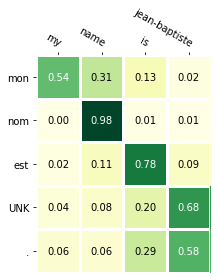

my name is jean-baptiste  - mon
my name is jean-baptiste  - nom
my name is jean-baptiste  - est
my name is jean-baptiste  - UNK
my name is jean-baptiste  - .



'mon nom est UNK .'

In [75]:
translator_en_fr.eval()
translator_en_fr("my name is jean-baptiste", attention_method = AttentionViewer)
translator_en_fr("my name is jean-baptiste", attention_method = AttentionViewerOnWords)

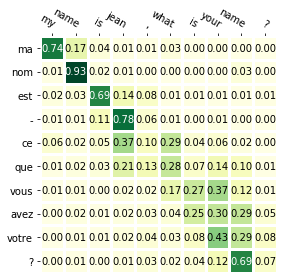

my name is jean , what is your name ?  - ma
my name is jean , what is your name ?  - nom
my name is jean , what is your name ?  - est
my name is jean , what is your name ?  - -
my name is jean , what is your name ?  - ce
my name is jean , what is your name ?  - que
my name is jean , what is your name ?  - vous
my name is jean , what is your name ?  - avez
my name is jean , what is your name ?  - votre
my name is jean , what is your name ?  - ?



'ma nom est - ce que vous avez votre ?'

In [120]:
translator_en_fr.eval()
translator_en_fr("my name is jean, what is your name ?", attention_method = AttentionViewer)
translator_en_fr("my name is jean, what is your name ?", attention_method = AttentionViewerOnWords)

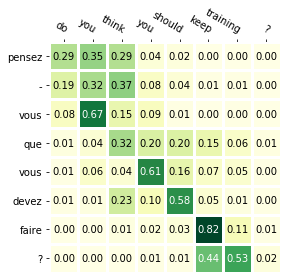

do you think you should keep training ?  - pensez
do you think you should keep training ?  - -
do you think you should keep training ?  - vous
do you think you should keep training ?  - que
do you think you should keep training ?  - vous
do you think you should keep training ?  - devez
do you think you should keep training ?  - faire
do you think you should keep training ?  - ?



'pensez - vous que vous devez faire ?'

In [117]:
translator_en_fr.eval()
sentence = 'do you think you should keep training ?'
translator_en_fr(sentence, attention_method = AttentionViewer)
translator_en_fr(sentence, attention_method = AttentionViewerOnWords)

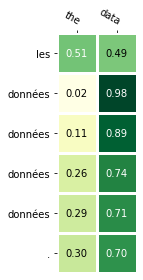

the data  - les
the data  - données
the data  - données
the data  - données
the data  - données
the data  - .



'les données données données données .'

In [119]:
translator_en_fr.eval()
translator_en_fr("The data", attention_method = AttentionViewer)
translator_en_fr("The data", attention_method = AttentionViewerOnWords)